# Moment Model of Atom Transfer Radical Polymerization

## 📖 Introduction

Radical polymerization (RP) includes a group of techniques that behave a lot like living polymerizations. These are officially called [reversible-deactivation radical polymerizations] (RDRP), but people still commonly refer to them as _living_ (or _controlled_) radical polymerizations.

What makes RDRP special is its reversible radical (de)activation mechanism. This process keeps a dynamic equilibrium between active and dormant chains, which is key to controlling the polymerization. If this back-and-forth happens frequently enough, each chain gets an almost equal chance to grow, leading to a more uniform molar mass distribution. 

[Atom transfer radical polymerization] (ATRP) is one of the most popular RDRP techniques. It relies on a transition-metal catalyst to switch polymer chains between active and dormant states. In its simplest form, the ATRP mechanism comprises the following elementary reactions:

\begin{align*}
R_n X + A                 & \overset{k_a}{\underset{k_{da}}{\rightleftarrows}}  R_n^{\cdot}  + XA \\
R_n^{\cdot} + M           & \xrightarrow{k_p}                  R_{n+1}^{\cdot} \\
R_n^{\cdot} + R_m^{\cdot} & \xrightarrow{k_{tc}}               P_{n+m} \\
R_n^{\cdot} + R_m^{\cdot} & \xrightarrow{k_{td}}               P_n + P_m
\end{align*}

where $A$ denotes the activator, $XA$ the persistent radical, $R_0 X$ the initiator, $R_n^{\cdot}$ an active chain, $R_n X$ a dormant chain, and $P_n$ a dead polymer chain. For a closed system with constant volume and constant rate coefficients, the corresponding transient species balances are:

\begin{align}
\frac{\textrm{d}[R_n X]}{\textrm{d}t} & = k_{da} [XA] [R_n^{\cdot}] - k_a [A] [R_n X] \\
\frac{\textrm{d}[R^{\cdot}_{n}]}{\textrm{d}t} & = k_a [A] [R_n X] - k_{da} [XA] [R_n^{\cdot}] + k_p[M]\left([R^{\cdot}_{n-1}]-[R_n^{\cdot}]\right)- 2 k_t [R_n^{\cdot}] \sum_{j=0}^{\infty}[R_j^{\cdot}] \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = k_{tc} \sum_{j=0}^{n}[R^{\cdot}_{n-j}][R^{\cdot}_{j}] + 2 k_{td} [R^{\cdot}_{n}] \sum_{j=0}^{\infty}[R^{\cdot}_{j}] \\
\frac{\textrm{d}[A]}{\textrm{d}t}   & = k_{da} [XA] \sum_{j=0}^{\infty} [R_j^{\cdot}] - k_a [A] \sum_{j=0}^{\infty} [R_j X] \\
\frac{\textrm{d}[XA]}{\textrm{d}t}  & = - \frac{\textrm{d}[A]}{\textrm{d}t} \\
\frac{\textrm{d}[M]}{\textrm{d}t}   & = - k_p [M] \sum_{j=0}^{\infty}[R^{\cdot}_{j}]
\end{align}

where $k_t = k_{tc} + k_{td}$.

We could solve these equations numerically, as shown in [Notebook 5], but for this tutorial, we'll focus on the method of moments. Specifically, we focus on the first three moments of the dormant, active, and dead polymer distributions:

\begin{align}
\psi_j    & = \sum_{n=0}^{\infty} n^j [R_n X] \\
\mu_j     & = \sum_{n=0}^{\infty} n^j [R_n^{\cdot}] \\
\lambda_j & = \sum_{n=0}^{\infty} n^j [P_n]
\end{align}

with $j \in \{0,1,2\}$. The corresponding moment and species balances are:

\begin{align}
\frac{\textrm{d}\psi_i}{\textrm{d}t}    & = k_{da} [XA] \mu_i - k_a [A] \psi_i \\
\frac{\textrm{d}\mu_0}{\textrm{d}t}     & = -\frac{\textrm{d}\psi_0}{\textrm{d}t} - 2 k_t \mu_0^2  \\
\frac{\textrm{d}\mu_1}{\textrm{d}t}     & = -\frac{\textrm{d}\psi_1}{\textrm{d}t} + k_p [M] \mu_0 - 2 k_t \mu_0 \mu_1  \\
\frac{\textrm{d}\mu_2}{\textrm{d}t}     & = -\frac{\textrm{d}\psi_2}{\textrm{d}t} + k_p [M] \left(\mu_0 + 2 \mu_1 \right)- 2 k_t \mu_0 \mu_2  \\
\frac{\textrm{d}\lambda_0}{\textrm{d}t} & = (k_{tc} + 2 k_{td}) \mu_0^2 \\
\frac{\textrm{d}\lambda_1}{\textrm{d}t} & = 2 k_{t} \mu_0 \mu_1 \\
\frac{\textrm{d}\lambda_2}{\textrm{d}t} & = 2 k_{t} \mu_0 \mu_2 + 2 k_{tc} \mu_1^2 \\
\frac{\textrm{d}[A]}{\textrm{d}t}       & = \frac{\textrm{d}\psi_0}{\textrm{d}t} \\
\frac{\textrm{d}[XA]}{\textrm{d}t}      & = - \frac{\textrm{d}\psi_0}{\textrm{d}t} \\
\frac{\textrm{d}[M]}{\textrm{d}t}       & = - k_p [M] \mu_0
\end{align}

forming a closed set of 12 ordinary differential equations (ODEs). If we wanted, we could simplify things a bit more since the balances for $A$, $XA$, and $\psi_0$ are trivially related to each other.

Enough theory! Let us numerically solve this ATRP model for representative reaction conditions.

[reversible-deactivation radical polymerizations]: https://en.wikipedia.org/wiki/Reversible-deactivation_polymerization  
[atom transfer radical polymerization]: https://en.wikipedia.org/wiki/Atom_transfer_radical_polymerization
[Notebook 5]: ./05_radical_pbe_batch_polymerization.ipynb

## 🧮 Model Implementation

In [1]:
from enum import IntEnum

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

To improve code readability, we define an enum mapping the variable names to the corresponding row index in the state vector and related arrays.

In [2]:
class Ix(IntEnum):
    A    = 0
    XA   = 1
    M    = 2
    mu0  = 3
    mu1  = 4
    mu2  = 5
    psi0 = 6
    psi1 = 7
    psi2 = 8
    lbd0 = 9
    lbd1 = 10
    lbd2 = 11

Now, we implement a function to compute the derivative of the state vector, which contains the concentrations/moments of all species.

In [3]:
def model_xdot(t: float,
               x: np.ndarray,
               ka: float,
               kda: float,
               kp: float,
               ktc: float,
               ktd: float
               ) -> np.ndarray:
    """Calculate derivative of the state vector, dx/dt.

    x = [A, XA, M, mu0..mu2, psi0..psi2, lbd0..lbd2]

    Parameters
    ----------
    t : float
        Time.
    x : np.ndarray
        State vector.
    ka : float
        Activation rate coefficient.
    kda : float
        Deactivation rate coefficient.
    kp : float
        Propagation rate coefficient.
    ktc : float
        Termination by combination rate coefficient.
    ktd : float
        Termination by disproportionation rate coefficient.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """

    # Unpack the state vector
    A   = x[Ix.A]
    XA  = x[Ix.XA]
    M   = x[Ix.M]
    mu  = x[Ix.mu0:Ix.mu2+1]
    psi = x[Ix.psi0:Ix.psi2+1]
 
    # Total termination rate
    kt = ktc + ktd

    # Derivatives
    xdot = np.empty_like(x)
    for i in range(0, 3):
        xdot[Ix.psi0 + i] = kda*XA*mu[i] - ka*A*psi[i]
        xdot[Ix.mu0  + i] = -xdot[Ix.psi0 + i] - 2*kt*mu[0]*mu[i]

    xdot[Ix.mu1] += kp*M*mu[0]
    xdot[Ix.mu2] += kp*M*(mu[0] + 2*mu[1])

    xdot[Ix.lbd0] = (ktc + 2*ktd)*mu[0]**2
    xdot[Ix.lbd1] = 2*kt*mu[0]*mu[1]
    xdot[Ix.lbd2] = 2*kt*mu[0]*mu[2] + 2*ktc*mu[1]**2

    xdot[Ix.A]  =  xdot[Ix.psi0]
    xdot[Ix.XA] = -xdot[Ix.psi0]
    xdot[Ix.M]  = -kp*M*mu[0]

    return xdot

Then, we perform the numerical integration using a suitable ODE solver. This system is _very_ [stiff](https://en.wikipedia.org/wiki/Stiff_equation), therefore we need to choose an implicit solver like `LSODA`.

In [4]:
def solve_model(M0: float,
                A0: float,
                RX0: float,
                ka: float,
                kda: float,
                kp: float,
                ktc: float,
                ktd: float,
                tend: float
                ) -> tuple[np.ndarray, np.ndarray]:
    """Solve the dynamic model.

    Parameters
    ----------
    M0 : float
        Initial monomer concentration (mol/L).
    A0 : float
        Initial activator concentration (mol/L).
    RX0 : float
        Initial initiator concentration (mol/L).
    ka : float
        Activation rate coefficient (L/(mol·s)).
    kda : float
        Deactivation rate coefficient (L/(mol·s)).
    kp : float
        Propagation rate coefficient (L/(mol·s)).
    ktc : float
        Termination by combination rate coefficient (L/(mol·s)).
    ktd : float
        Termination by disproportionation rate coefficient (L/(mol·s)).
    tend : float
        End time (s).

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        t, C.
    """
    # Initial conditions
    x0 = np.zeros(len(Ix))
    x0[Ix.A] = A0
    x0[Ix.M] = M0
    x0[Ix.psi0] = RX0

    solution = solve_ivp(model_xdot,
                         t_span=(0.0, tend),
                         y0=x0,
                         args=(ka, kda, kp, ktc, ktd),
                         method='LSODA',
                         rtol=1e-4,
                         atol=1e-10)

    # Unpack the solution
    t = solution.t
    C = solution.y

    # Check mass balance
    assert np.allclose(
        C[Ix.M] + C[Ix.mu1] + C[Ix.psi1] + C[Ix.lbd1], M0, rtol=1e-4), \
        "Oops, mass-balance violated!"

    return t, C

## ▶️ Run Simulation

For the base simulation, we take the kinetic parameters and reactant concentrations reported by [Tang & Matyjaszewski (2008)]. Feel free to experiment with these values, especially the magnitudes of $k_a$, $k_{da}$, and $k_t$.


[Tang & Matyjaszewski (2008)]: https://doi.org/10.1002/mats.200800050

In [5]:
M0 = 5.0     # mol/L
RX0 = M0/200 # mol/L
A0 = 2*RX0   # mol/L

ka = 1e0     # L/(mol·s) 
kda = 1e7    # L/(mol·s)
kp = 9e2     # L/(mol·s)
ktc = 1e8    # L/(mol·s)
ktd = 1e7    # L/(mol·s)

tend = 48*3600

In [6]:
t, C = solve_model(M0, A0, RX0, ka, kda, kp, ktc, ktd, tend)

## 📊 Plots

### Species Concentrations

To visualize the simulation results, let us first plot the concentrations of the various species over time.

Text(0.5, 23.52222222222222, 'Time (h)')

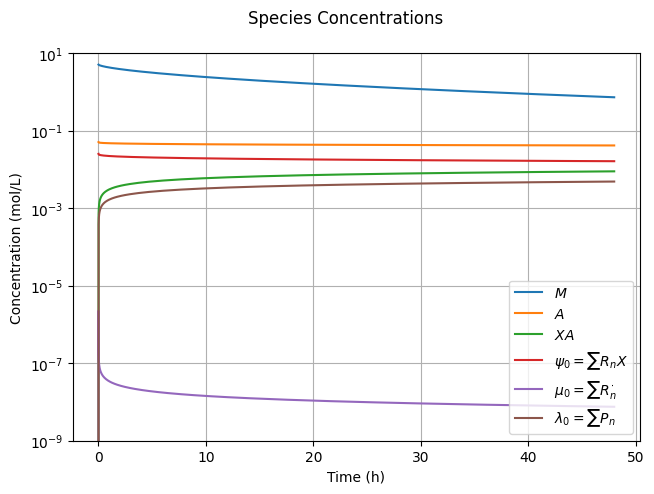

In [7]:
fig1, ax = plt.subplots()
fig1.suptitle("Species Concentrations")
fig1.tight_layout()
fig1.align_ylabels()

t_hour = t/3600

ax.plot(t_hour, C[Ix.M,    :], label=r"$M$")
ax.plot(t_hour, C[Ix.A,    :], label=r"$A$")
ax.plot(t_hour, C[Ix.XA,   :], label=r"$XA$")
ax.plot(t_hour, C[Ix.psi0, :], label=r"$\psi_0=\sum R_nX$")
ax.plot(t_hour, C[Ix.mu0,  :], label=r"$\mu_0=\sum R_n^{\cdot}$")
ax.plot(t_hour, C[Ix.lbd0, :], label=r"$\lambda_0=\sum P_n$")

ax.set_ylim(1e-9, 1e1)
ax.set_ylabel("Concentration (mol/L)")
ax.set_yscale('log')
ax.legend(loc='best')
ax.grid(True)
ax.set_xlabel("Time (h)")

It is worth taking the time to analyze and understand the results presented in this figure. Shortly after the reaction starts, the concentrations of $XA$ and $R^\cdot$ rise simultaneously. However, once $\mu_0=[R^\cdot]\approx 10^{-6}$ mol/L, the radical concentration peaks and begins to decay. To visualize this more clearly, you may wish to set `tend=1`. This occurs because $R^\cdot$ radicals can self-terminate, while $XA$ radicals cannot, leading to an accumulation of $XA$ and a low pseudo-equilibrium concentration of $R^\cdot$ radicals. This phenomenon, known as the [persistent radical effect], is a key feature of living RP.

[persistent radical effect]: https://en.wikipedia.org/wiki/Persistent_radical_effect

### Polymer Chain Length and Dispersity

(0.0, 100.0)

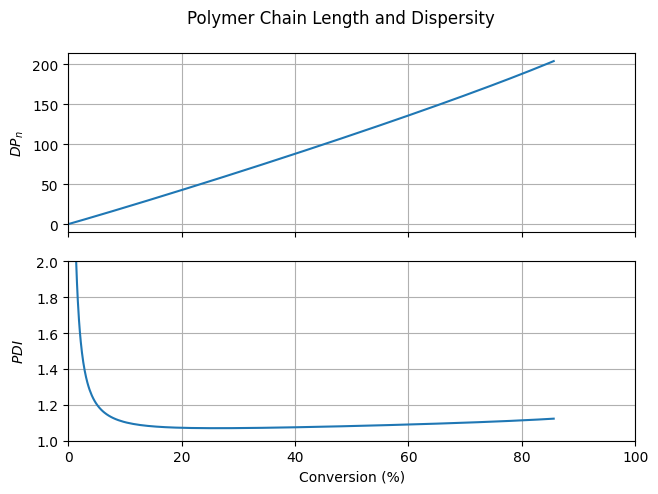

In [8]:
fig2, ax = plt.subplots(2, 1, sharex=True)
fig2.suptitle("Polymer Chain Length and Dispersity")
fig2.tight_layout()
fig2.align_ylabels()

# Moments of total polymer
moment_polymer = []
for i in range(0, 3):
    moment_polymer.append(
        np.sum(C[(Ix.psi0 + i, Ix.mu0 + i, Ix.lbd0 + i), :], axis=0)
    )

# Avegerage chain length and polydispersity index
DPn = moment_polymer[1]/(moment_polymer[0] + 1e-10)
DPw = moment_polymer[2]/(moment_polymer[1] + 1e-10)
PDI = DPw/(DPn + 1e-10)

# Monomer conversion
conversion_M = 1e2*(moment_polymer[1]/M0) 

ax[0].plot(conversion_M, DPn)
ax[0].set_ylabel(r"$DP_n$")
ax[0].grid(True)

ax[1].plot(conversion_M[1:], PDI[1:])
ax[1].set_ylabel(r"$PDI$")
ax[1].set_ylim(1.0, 2.0)
ax[1].grid(True)

ax[-1].set_xlabel("Conversion (%)")
ax[-1].set_xlim(0.0, 100.0)

The number average degree of polymerization increases almost linearly with monomer conversion and is close to the value expected for an ideal living polymerization ($DP_n = [M]_0 / [R_0X]_0 = 200$ at full monomer conversion). Furthermore, the PDI is significantly lower than the value that can be reached in a conventional batch radical polymerization. 

## 🔎 Questions

1. Determine the fraction of living chains at the end of the reaction (48 h).
2. Which parameters most strongly influence conversion?
3. Which parameters most strongly influence the PDI?
4. How does the rate of polymerization in ATRP compare to the rate in conventional RP?